In [1]:
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

from models import *
from utils import *
from datasets import *

d:\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# dataset

In [2]:
import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

# x = trainset[0][0].reshape(28,28)
# x.shape

traindata = [i[0].unsqueeze(0) for i in trainset]
trainlabel = [i[1] for i in trainset]
testdata = [i[0].unsqueeze(0) for i in testset]
testlabel = [i[1] for i in testset]

X_train = torch.vstack(traindata)
y_train = torch.tensor(trainlabel)
X_test = torch.vstack(testdata)
y_test = torch.tensor(testlabel)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [3]:
# construct graph of nearest neighbors
graph_constructor_train =  ConstructUMAPGraph(metric='euclidean', n_neighbors=15, batch_size=1000, random_state=42)
epochs_per_sample_train, head_train, tail_train, weight_train = graph_constructor_train(X_train)

graph_constructor_test =  ConstructUMAPGraph(metric='euclidean', n_neighbors=15, batch_size=1000, random_state=42)
epochs_per_sample_test, head_test, tail_test, weight_test = graph_constructor_test(X_test)

Tue Nov  7 23:52:18 2023 Building RP forest with 17 trees
Tue Nov  7 23:52:22 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Tue Nov  7 23:52:46 2023 Building RP forest with 10 trees
Tue Nov  7 23:52:46 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations


In [12]:
# num_edges = len(edges_from_exp)
# batch_size = 1024

# batches_per_epoch = int(num_edges / batch_size / 5)
# batches_per_epoch

1658

In [51]:
# rand_index = np.random.randint(0, len(edges_to_exp) - 1, size=batch_size)
# rand_index, len(rand_index)

In [52]:
# batch_index_to = edges_to_exp[rand_index]
# batch_index_to, len(batch_index_to)

In [53]:
# batch_index_from = edges_from_exp[rand_index]
# batch_index_from, len(batch_index_from)

In [54]:
# batch_to = torch.Tensor(X[batch_index_to])
# print(batch_to.shape, len(batch_to))

# batch_from = torch.Tensor(X[batch_index_from])
# print(batch_from.shape, len(batch_from))

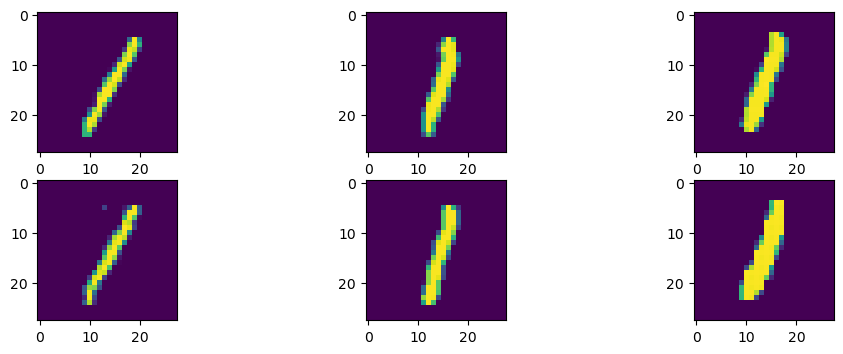

In [4]:
# plot examples of nearest neighbors
fig, ax = plt.subplots(2,3,figsize=(12,4))
ids = np.random.randint(0, len(X_train), size=3)
for j in range(3):
    ax[0][j].imshow(X_train[head_train[ids[j]],0,:,:])
    ax[1][j].imshow(X_train[tail_train[ids[j]],0,:,:])

In [5]:
batch_size = 1000 # 1024

train_dataset = UMAPDataset(
    data=X_train, labels=y_train, 
    epochs_per_sample=epochs_per_sample_train, head=head_train, tail=tail_train, weight=weight_train, 
    device='cuda', batch_size=batch_size, feedback=None
)
test_dataset = UMAPDataset(
    data=X_test, labels=y_test, 
    epochs_per_sample=epochs_per_sample_test, head=head_test, tail=tail_test, weight=weight_test, 
    device='cuda', batch_size=batch_size, feedback=None
)

criterion = UMAPLoss(device='cuda', min_dist=0.1, batch_size=batch_size, negative_sample_rate=5, edge_weight=None, repulsion_strength=1.0)

# training

In [14]:
class Encoder(nn.Module):

    def __init__ (self, output_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128*6*6, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        return x

model = Encoder(output_dim=2).cuda()
print(model)
print("num params: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Encoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4608, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
)
num params: 2697986


In [7]:
for x, _, _, _, _, _ in train_dataset.get_batches():
    break
print(x.shape)
x = F.relu(model.conv1(x))
print(x.shape)
x = F.relu(model.conv2(x))
print(x.shape)

# (W - F + 2P) / S + 1
# W: input size; F: kernel size; P: padding; S: stride

torch.Size([1000, 1, 28, 28])
torch.Size([1000, 64, 13, 13])
torch.Size([1000, 128, 6, 6])


### normal

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
for epoch in range(20):
    train_loss = 0.
    for batch_to, batch_from in tqdm(dataset.get_batches()):
        optimizer.zero_grad()
        embedding_to = model(batch_to)
        embedding_from = model(batch_from)
        loss = criterion(embedding_to, embedding_from)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(train_loss)
    print('epoch: {}, loss: {}'.format(epoch, train_loss))

1658it [00:36, 45.05it/s]


epoch: 0, loss: 318.03750263154507


1658it [00:36, 45.28it/s]


epoch: 1, loss: 240.1528361439705


1658it [00:37, 44.56it/s]


epoch: 2, loss: 223.47370879352093


1658it [00:36, 45.30it/s]


epoch: 3, loss: 215.08936947584152


1658it [00:36, 45.02it/s]


epoch: 4, loss: 208.55754387378693


1658it [00:37, 44.71it/s]


epoch: 5, loss: 204.53035256266594


1658it [00:37, 44.55it/s]


epoch: 6, loss: 201.10685642063618


1658it [00:37, 44.30it/s]


epoch: 7, loss: 197.34721734374762


1658it [00:37, 44.52it/s]


epoch: 8, loss: 195.87135761231184


1658it [00:37, 43.71it/s]


epoch: 9, loss: 193.89846673607826


1658it [00:36, 44.89it/s]


epoch: 10, loss: 193.11345309764147


1658it [00:38, 42.92it/s]


epoch: 11, loss: 192.27942787110806


1658it [00:36, 44.85it/s]


epoch: 12, loss: 191.27620838582516


1658it [00:37, 44.32it/s]


epoch: 13, loss: 188.89346952736378


1658it [00:37, 44.59it/s]


epoch: 14, loss: 188.81027987599373


1658it [00:37, 44.48it/s]


epoch: 15, loss: 188.43864223361015


1658it [00:37, 43.83it/s]


epoch: 16, loss: 188.32329916208982


1658it [00:37, 43.95it/s]


epoch: 17, loss: 186.9248784184456


1658it [00:37, 44.54it/s]


epoch: 18, loss: 186.93035701662302


1658it [00:37, 44.45it/s]

epoch: 19, loss: 186.0362358763814


In [57]:
torch.save(model.state_dict(), 'encoder_weights.pt') 

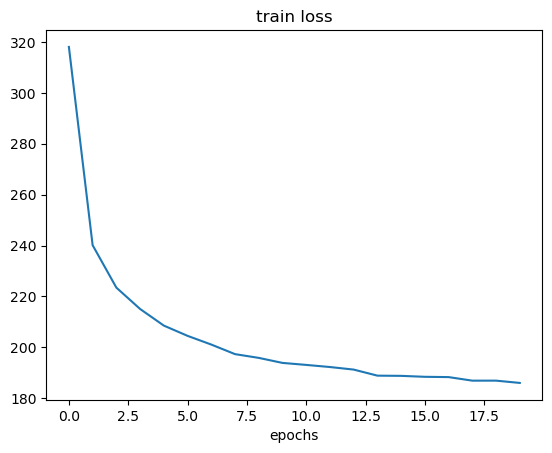

In [58]:
plt.plot(train_losses)
plt.xlabel('epochs')
plt.title('train loss')
plt.show()

In [11]:
model = Encoder(output_dim=2).cuda()
model.load_state_dict(torch.load('encoder_weights.pt'))

<All keys matched successfully>

In [12]:
from torch.utils.data import DataLoader, TensorDataset

test_loader = DataLoader(TensorDataset(torch.Tensor(X), torch.Tensor(X)), batch_size=1024, shuffle=False)

outputs = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x.cuda()).detach().cpu().numpy()
        outputs.append(output)

outputs = np.concatenate(outputs, axis=0)
outputs.shape

(70000, 2)

In [14]:
def normalise(z):
    """normalise coordinates to 0~1

    :param z: normalised coordinates
    """
    if type(z) == type(torch.ones(1)):
        z0 = (z[:,0] - torch.min(z[:,0])) / (torch.max(z[:,0]) - torch.min(z[:,0]))
        z1 = (z[:,1] - torch.min(z[:,1])) / (torch.max(z[:,1]) - torch.min(z[:,1]))
        z = torch.vstack([z0.reshape(-1,1), z1.reshape(-1,1)])
    
    if type(z) == type(np.ones(1)):
        z0 = (z[:,0] - np.min(z[:,0])) / (np.max(z[:,0]) - np.min(z[:,0]))
        z1 = (z[:,1] - np.min(z[:,1])) / (np.max(z[:,1]) - np.min(z[:,1]))
        z = np.hstack([z0.reshape(-1,1), z1.reshape(-1,1)])

    return z

outputs_normalised = normalise(outputs)
outputs_normalised.shape

(70000, 2)

In [20]:
np.save("./umap_data_reducted.npy", np.hstack([normalise(outputs), np.array(y).reshape(-1,1)]))

d:\anaconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 9600x7200 with 0 Axes>

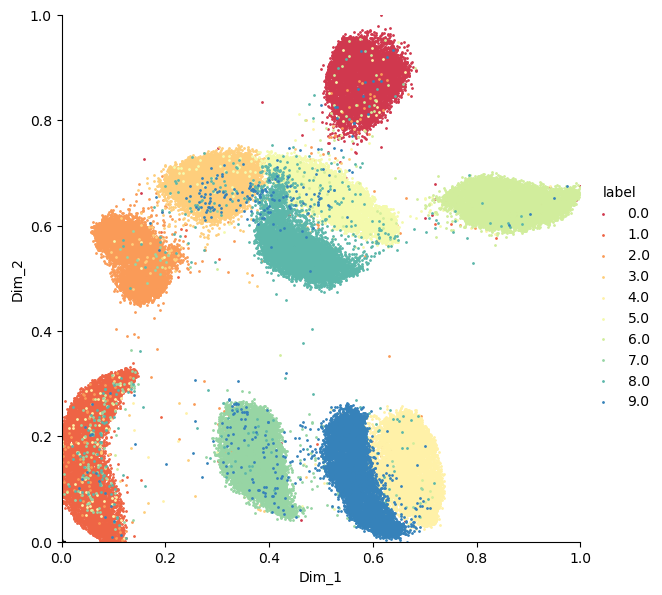

In [15]:
draw_z(z=normalise(outputs), cls=torch.tensor(y), s=1, x_highlight=0.0, y_highlight=0.0)

### DR loss + MSE Scag loss

In [12]:
metricsmlp = ScagEstimator(size_in=1000, size_hidden=100, size_out=9).cuda()
metricsmlp.load_state_dict(torch.load("./data/pretrain_results/MetricsMLP.pt"))
print(sum([p.numel() for p in metricsmlp.parameters()]))
metricsmlp.eval()

222218


ScagEstimator(
  (layerx): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=9, bias=True)
    (5): ReLU()
  )
  (layery): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=9, bias=True)
    (5): ReLU()
  )
)

d:\anaconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 9600x7200 with 0 Axes>

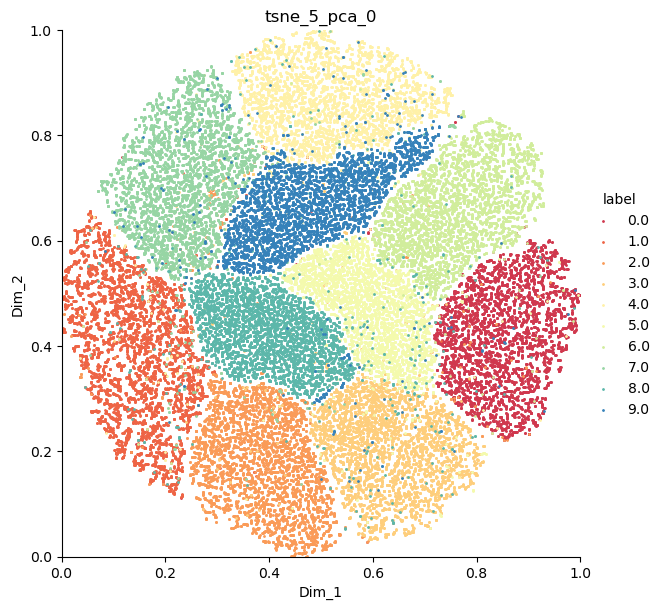

tensor([[0.0000e+00, 5.2164e-01, 2.1949e-03, 2.1290e-02, 6.6007e-03, 6.7319e-01,
         9.7099e-02, 3.5223e-01, 1.8745e-05]], device='cuda:0',
       requires_grad=True)

In [9]:
name, z, y, scags_gt = torch.load("./data/pretrain_data_60k/12.pt")
# print(name, z.shape, y.shape, scags.shape)
draw_z(z=z, cls=y, s=1, title=name)

scags_gt = scags_gt.cuda()
scags_gt.requires_grad_()
scags_gt

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
DR_losses = []
Scag_losses = []

test_losses = []
test_DR_losses = []
test_Scag_losses = []

best_epoch = 0
best_test_loss = 100.
best_train_loss = 100.

for epoch in range(100):

    # train
    train_loss = []
    DR_loss = []
    Scag_loss = []
    for batch_to, batch_from, _, _, _, _ in tqdm(train_dataset.get_batches()):
        optimizer.zero_grad()

        embedding_to = model(batch_to)
        embedding_from = model(batch_from)
        scag_to = metricsmlp(embedding_to)
        scag_from = metricsmlp(embedding_from)

        # loss = criterion(embedding_to, embedding_from)
        dr_loss = criterion(embedding_to, embedding_from)
        scag_loss_to = F.mse_loss(scag_to, scags_gt)
        scag_loss_from = F.mse_loss(scag_from, scags_gt)

        loss = dr_loss + scag_loss_to + scag_loss_from

        train_loss.append(loss.item())
        DR_loss.append(dr_loss.item())
        Scag_loss.append((scag_loss_to.item(), scag_loss_from.item()))

        loss.backward()

        optimizer.step()

    train_losses.append(np.mean(train_loss))
    DR_losses.append(np.mean(DR_loss))
    Scag_losses.append((np.mean([i[0] for i in Scag_loss]), np.mean([i[1] for i in Scag_loss])))

    print('epoch: {} - train, loss: {}, DR_loss: {}, Scag_loss: {}'.format(epoch, train_losses[-1], DR_losses[-1], Scag_losses[-1]))


    # test
    test_loss = []
    test_DR_loss = []
    test_Scag_loss = []
    
    model.eval()

    for batch_to, batch_from, _, _, _, _ in tqdm(test_dataset.get_batches()):
        embedding_to = model(batch_to)
        embedding_from = model(batch_from)
        scag_to = metricsmlp(embedding_to)
        scag_from = metricsmlp(embedding_from)

        dr_loss = criterion(embedding_to, embedding_from)
        scag_loss_to = F.mse_loss(scag_to, scags_gt)
        scag_loss_from = F.mse_loss(scag_from, scags_gt)

        loss = dr_loss + scag_loss_to + scag_loss_from

        test_loss.append(loss.item())
        test_DR_loss.append(dr_loss.item())
        test_Scag_loss.append((scag_loss_to.item(), scag_loss_from.item()))

        loss.backward()

        optimizer.step()

    test_losses.append(np.mean(test_loss))
    test_DR_losses.append(np.mean(test_DR_loss))
    test_Scag_losses.append((np.mean([i[0] for i in test_Scag_loss]), np.mean([i[1] for i in test_Scag_loss])))

    print('epoch: {} - test, loss: {}, DR_loss: {}, Scag_loss: {}'.format(epoch, test_losses[-1], test_DR_losses[-1], test_Scag_losses[-1]))

    if test_losses[-1] < best_test_loss:
        torch.save(model.state_dict(), "./data/pretrain_results/DR_weights_scags.pt")
        best_epoch = epoch
        best_test_loss = test_losses[-1]
        best_train_loss = train_losses[-1]

    model.train()

1449it [00:34, 42.00it/s]


epoch: 0 - train, loss: 0.7168304637187591, DR_loss: 0.48796859681811966, Scag_loss: (0.11465857845388502, 0.11420328661367513)


120it [00:02, 42.49it/s]


KeyboardInterrupt: 